In [1]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from pytorch_lightning import Trainer

Load MNIST data, convert to Tensor and normalize

X data is full training dataset

Y data is only 5s

In [2]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
mnist_dataset = MNIST('./mnist_data/', train=True, download=True, transform=transform)
x_dataset = torch.unsqueeze(torch.vstack([d[0] for d in mnist_dataset]), dim=1)
y_dataset = torch.unsqueeze(torch.vstack([d[0] for d in mnist_dataset if d[1]==5]), dim=1)

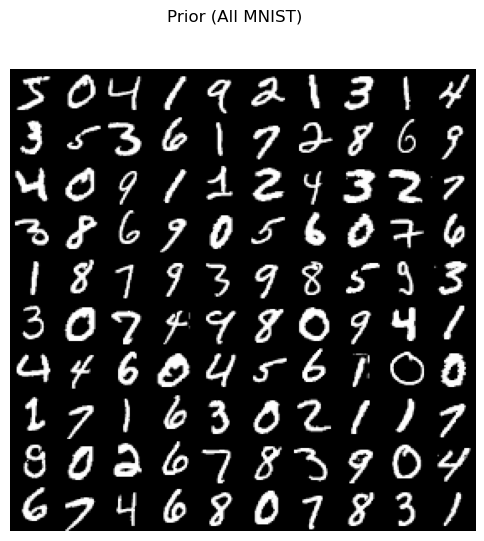

In [3]:
fig, axs = plt.subplots(10,10, figsize=(6,6))
for i, x in enumerate(x_dataset[:100]):
    axs.flatten()[i].imshow(x.detach().permute(1, 2, 0), cmap='Greys_r')
    axs.flatten()[i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("Prior (All MNIST)")
plt.show()

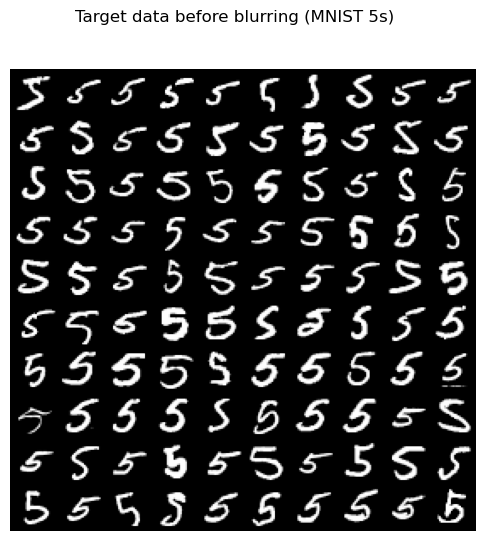

In [4]:
fig, axs = plt.subplots(10,10, figsize=(6,6))
for i, x in enumerate(y_dataset[:100]):
    axs.flatten()[i].imshow(x.detach().permute(1, 2, 0), cmap='Greys_r')
    axs.flatten()[i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("Target data before blurring (MNIST 5s)")
plt.show()

Mechanistic model is Blurring using Average Pooling filter

In [5]:
blur = nn.AvgPool2d(kernel_size=7, stride=1)

In [6]:
y_dataset = blur(y_dataset)

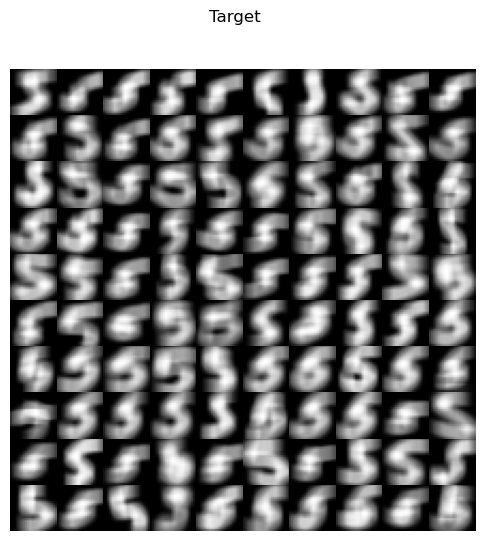

In [7]:
fig, axs = plt.subplots(10,10, figsize=(6,6))
for i, x in enumerate(y_dataset[:100]):
    axs.flatten()[i].imshow(x.detach().permute(1, 2, 0), cmap='Greys_r')
    axs.flatten()[i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("Target")
plt.show()

Repeat Y dataset to match size of X dataset

In [8]:
y_dataset = y_dataset.repeat((-(-x_dataset.shape[0]//y_dataset.shape[0]),1,1,1))[:x_dataset.shape[0]]

In [9]:
print(x_dataset.shape)
print(y_dataset.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 1, 22, 22])


In [10]:
x_shape = x_dataset.shape[-2:]
y_shape = y_dataset.shape[-2:]
z_dim = 100

### Set up rGAN model

In [11]:
import rgan

In [12]:
from importlib import reload
reload(rgan)

<module 'rgan' from '/home/hm/rgan-demo-pytorch/examples/MNIST/rgan.py'>

In [13]:
G, R, D_X, D_Y = rgan.MNISTNetsRGAN(z_dim=z_dim, x_shape=x_shape, y_shape=y_shape)

In [14]:
prior_hparams_dict = {'batch_size': 256,
                      'lr_g': 1e-4,
                      'lr_d_x': 2e-5,
                      'lr_d_y': 2e-5,
                      'wx': 1.0,
                      'wy': 0.0,
                      'wr': 3.0,
                      'epochs': 100,
                     }

rgan_hparams_dict = {'batch_size': 256,
                     'lr_g': 1e-4,
                     'lr_d_x': 2e-5,
                     'lr_d_y': 2e-5,
                     'wx': 0.03,
                     'wy': 1.0,
                     'wr': 3.0,
                     'epochs': 200,
                    }

rgan_model = rgan.rGAN(mm=blur, 
                       x_dataset=x_dataset, 
                       y_dataset=y_dataset,
                       hparams=prior_hparams_dict,
                       G=G, R=R, D_X=D_X, D_Y=D_Y,
                       z_dim=z_dim,
                       train_stage = 'prior'
                       )

#### Train 'prior' stage (Regular GAN for MNIST)

In [15]:
trainer = Trainer(max_epochs=rgan_model.hparams.epochs, accelerator='auto')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hm/miniconda3/envs/pytorch_cuda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [16]:
trainer.fit(rgan_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | mm   | AvgPool2d     | 0     
1 | G    | Generator     | 2.9 M 
2 | R    | Reconstructor | 2.4 M 
3 | D_X  | Discriminator | 733 K 
4 | D_Y  | Discriminator | 731 K 
---------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.046    Total estimated model params size (MB)
/home/hm/miniconda3/envs/pytorch_cuda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/hm/miniconda3/envs/pytorch_cuda/lib/python3.10/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")
`Trainer.fit` stopped: `max_epochs=100` reached.


#### Check 'prior' stage training by sampling base variable (z) and generating MNIST samples using G(z)

In [34]:
z_prior = torch.randn(100, z_dim)

In [35]:
gen_x_prior = G(z_prior)

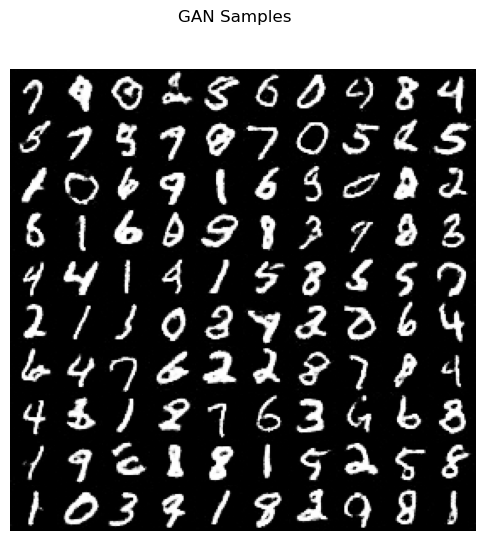

In [20]:
fig, axs = plt.subplots(10,10, figsize=(6,6))
for i, x in enumerate(gen_x_prior):
    axs.flatten()[i].imshow(x.detach().permute(1, 2, 0), cmap='Greys_r')
    axs.flatten()[i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("GAN Samples")
plt.show()

## rGAN training stage

In [37]:
rgan_model.train_stage = 'rgan'
rgan_model.hparams.update(rgan_hparams_dict)

In [38]:
trainer = Trainer(max_epochs=rgan_model.hparams.epochs, accelerator='auto')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [39]:
trainer.fit(rgan_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | mm   | AvgPool2d     | 0     
1 | G    | Generator     | 2.9 M 
2 | R    | Reconstructor | 2.4 M 
3 | D_X  | Discriminator | 733 K 
4 | D_Y  | Discriminator | 731 K 
---------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.046    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


#### Check 'rGAN' stage training by sampling base variable (z) and generating samples using G(z)

In [48]:
z_rgan = torch.randn(100, z_dim)

In [49]:
gen_x_rgan = G(z_rgan)

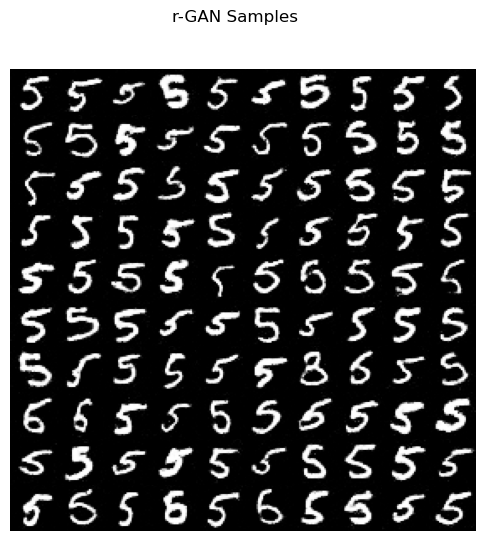

In [51]:
fig, axs = plt.subplots(10,10, figsize=(6,6))
for i, x in enumerate(gen_x_rgan):
    axs.flatten()[i].imshow(x.detach().permute(1, 2, 0), cmap='Greys_r')
    axs.flatten()[i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("r-GAN Samples")
plt.show()

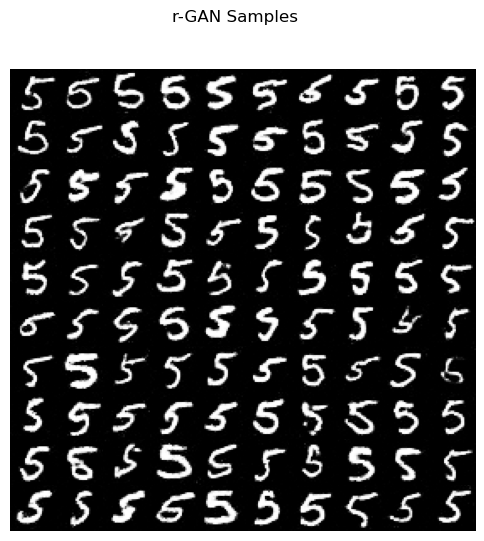

In [47]:
fig, axs = plt.subplots(10,10, figsize=(6,6))
for i, x in enumerate(gen_x_rgan):
    axs.flatten()[i].imshow(x.detach().permute(1, 2, 0), cmap='Greys_r')
    axs.flatten()[i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("r-GAN Samples")
plt.show()